# Project experiments

In [1]:
import time
from engine import Engine
import numpy as np
import nltk
from nltk.corpus import brown, reuters, gutenberg, inaugural
import matplotlib.pyplot as plt


In [2]:
nltk.download('brown')
nltk.download('reuters')
nltk.download('gutenberg')
nltk.download('inaugural')

[nltk_data] Downloading package brown to /home/codespace/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package inaugural to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

In [3]:
engine = Engine('data/shorthand_dict.json')

In [4]:
from dahuffman import HuffmanCodec

In [9]:
def print_table_header(name, characteristics):
    table_width = 120
    print('#' * table_width)
    print('#' + ' ' * (((table_width - 2) - len(name)) // 2) + name + ' ' * (((table_width - 2) - len(name)) // 2) + '#')
    print('#' + ' ' * (((table_width - 2) - len(characteristics)) // 2) + characteristics + ' ' * (((table_width - 2) - len(characteristics)) // 2) + '#')
    print('#' * table_width)
    print('orig. size\tcomp. size\tcomp. ratio\thit rate\tduration\tHuff. ratio\tcomb. ratio\tfile name')
    print('----------\t----------\t----------\t----------\t----------\t----------\t----------\t----------')

def print_table_footer(ratio, hit, dur, huff, comb):
    print('----------\t----------\t--AVERAGES--\t----------\t----------\t----------')
    print('comp. ratio\thit rate\tduration\tHuff. ratio\tcomb. ratio')
    print('----------\t----------\t----------\t----------\t----------\t----------\t----------\t----------')
    print('{:.2f}%\t\t{:.2f}%\t\t{:.3f}s\t\t{:.2f}%\t\t{:.2f}'.format(ratio, hit, dur, huff, comb))

def print_result(original_file_size, compressed_file_size, compressed_words, total_words, duration, huffman_only, huffman_also, file):
    print('{} bytes\t{} bytes\t{:.2f}%\t\t{:.2f}%\t\t{:.3f}\t\t{:.2f}%\t\t{:.2f}%\t\t{}'.format(original_file_size, compressed_file_size, compressed_file_size / original_file_size * 100, compressed_words / total_words * 100, duration, huffman_only, huffman_also, file))

In [11]:
def run_experiment(corpus, name, documents):
    word_counts = []
    for file in corpus.fileids():
        word_counts.append(len(corpus.words(fileids=[file])))
    print_table_header(name, '{} documents | avg {} words'.format(len(word_counts), round(np.mean(word_counts))))
    avg_ratio, avg_hit, avg_dur, avg_huff, avg_comb = [], [], [], [], []
    for file in corpus.fileids()[:documents]:
        text = corpus.raw(file)
        huffman_only = len(HuffmanCodec.from_data(text).encode(text))
        original_file_size = len(text)
        compressed_text, compressed_words, total_words, duration = engine.compress(text, opts = {'lossless': True, 'verbose': False })
        compressed_file_size = len(compressed_text)

        huffman_also = len(HuffmanCodec.from_data(compressed_text).encode(compressed_text))
        avg_ratio.append(compressed_file_size / original_file_size * 100)
        avg_hit.append(compressed_words / total_words * 100)
        avg_dur.append(duration)
        avg_huff.append(huffman_only / original_file_size * 100)
        avg_comb.append(huffman_also / original_file_size * 100)
        
        print_result(original_file_size, compressed_file_size, compressed_words, total_words, duration, (huffman_only / original_file_size) * 100, (huffman_also / original_file_size) * 100, file)
    print_table_footer(np.mean(avg_ratio), np.mean(avg_hit), np.mean(avg_dur), np.mean(avg_huff), np.mean(avg_comb))

In [12]:
run_experiment(inaugural, 'C-Span', len(inaugural.fileids()))
run_experiment(reuters, 'Reuters', 50)
run_experiment(gutenberg, 'Gutenberg', 3)

########################################################################################################################
#                                                        C-Span                                                        #
#                                            59 documents | avg 2592 words                                            #
########################################################################################################################
orig. size	comp. size	comp. ratio	hit rate	duration	Huff. ratio	comb. ratio	file name
----------	----------	----------	----------	----------	----------	----------	----------
8619 bytes	6447 bytes	74.80%		71.63%		4.804		53.57%		38.93%		1789-Washington.txt
791 bytes	599 bytes	75.73%		66.67%		0.541		54.49%		40.46%		1793-Washington.txt
13877 bytes	10359 bytes	74.65%		70.71%		8.310		53.28%		38.70%		1797-Adams.txt
10137 bytes	7724 bytes	76.20%		68.36%		6.136		53.65%		39.84%		1801-Jefferson.txt
12908 bytes	9676 bytes	7

In [7]:
dur = []
huff_dur = []
for n in range(10, 100, 10):
    doc_size = n * 10
    text = inaugural.raw('1789-Washington.txt')[:doc_size]
    start_time = time.time()
    HuffmanCodec.from_data(text).encode(text)
    huffman_duration = time.time() - start_time
    _, _, _, duration = engine.compress(text, opts = {'lossless': True, 'verbose': False })
    dur.append(duration)
    huff_dur.append(huffman_duration)

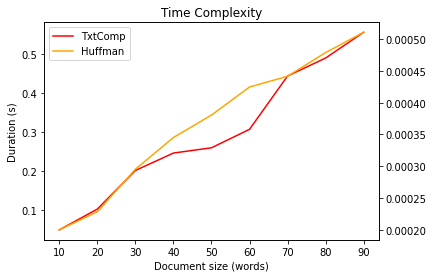

In [10]:
plt.title('Time Complexity')
plt.xlabel('Document size (words)')
plt.ylabel('Duration (s)')

ax1 = plt.subplot()
l1, = ax1.plot(range(10, 100, 10), dur, color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(range(10, 100, 10), huff_dur, color='orange')

plt.legend([l1, l2], ["TxtComp", "Huffman"])

plt.show()